# Train a binary classifier on a cutout

- Workshop: **Tutorial: High performance computing with Python and RS-DAT, EO summer school 2025**

- Date: September 3, 2025 

In this notebook, we train a binary classifier on a cutout of a Sentinel-2 RGB image. [Later](./step2_prediction_on_large_data.ipynb), we will apply the trained model to classify the full image.

**NOTE**: The workflow illustrated in this notebook has been extremely simplified and does not adhere to ML best practices. For instance, we did not reserve test data to evaluate the model performance. The purpose of this notebook is to demonstrate how to scale up (inference) workflows to large datasets.

In [1]:
from pathlib import Path

import joblib # to save and load the model
import rioxarray
import geopandas as gpd
import xarray as xr
import numpy as np

from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier

---

## Data used in this notebook

The data used in this workshop can be found on Zenodo ([link](https://zenodo.org/records/16941613)):

In [2]:
# Uncomment the following line to retrive the dataset
# !wget https://zenodo.org/api/records/16941613/files-archive

Not that on the [Spider](https://doc.spider.surfsara.nl/en/latest/) platform, which we use for demonstraiton, the data is already available under the following path:

In [3]:
data_dir = Path("/project/remotesensing/Data/eo-summer-school")

The input data include:
- `sentinel2_rgb_mosaic.tif`: Sentinel-2 RGB mosaic representing the area of interest at 10 m resolution.
- `waterbody_labels.gpkg`: manually-created polygons with label values, where label 1 represents water bodies and label 0 represents non-water bodies.

In this notebook, we use the label data to train the binary classifier. In [step 2](./step2_prediction_on_large_data.ipynb), we will apply the trained model to the full extent of the Sentinel-2 mosaic.

---

## Inspect the Area of Interest (AoI)

We start by inspecting the full image. It is saved in Cloud Optimized GeoTIFF (COG) format, which means that we can open a coarser zoom leval (an "overview") instead of loading the full image into memory. Here we use `overview_level = 1` (i.e. the second overview) to load a 4x4 downsampled image.

In [4]:
# Load the RGB image with overviews level 1
# This is a lazy loading without persisting data in memory
path_rgb = data_dir / "sentinel2_rgb_mosaic.tif"
rgb = rioxarray.open_rasterio(path_rgb, overview_level=1)
rgb

<xarray.DataArray (band: 3, y: 7729, x: 6690)> Size: 310MB
[155121030 values with dtype=uint16]
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 54kB 5.206e+05 5.206e+05 ... 7.881e+05 7.882e+05
  * y            (y) float64 62kB 5.937e+06 5.937e+06 ... 5.628e+06 5.628e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

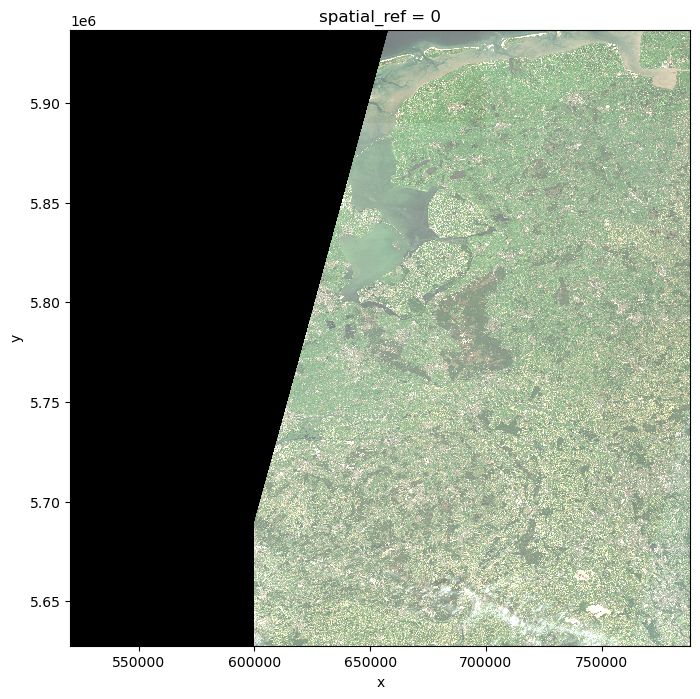

In [5]:
fig, ax = plt.subplots(figsize=(8, 8))
rgb.plot.imshow(ax=ax, robust=True)

As we can see, the area of interest (AoI) covers the central-east of the Netherlands and the western part of Germany. Our goal is to segment waterbodies and non-waterbodies in this region.

## Loading and exploring the training data

Now we load a cutout of this image, which corresponds to the extend of the label polygons:

In [6]:
path_labels = data_dir / "waterbody_labels.gpkg"

rgb = rioxarray.open_rasterio(path_rgb)
labels = gpd.read_file(path_labels)

# Make sure raster and vector data are in the same CRS
labels = labels.to_crs(rgb.rio.crs)

# Crop the image to the label extend
rgb_cutout = rgb.rio.clip_box(*labels.total_bounds)

<Axes: title={'center': 'spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

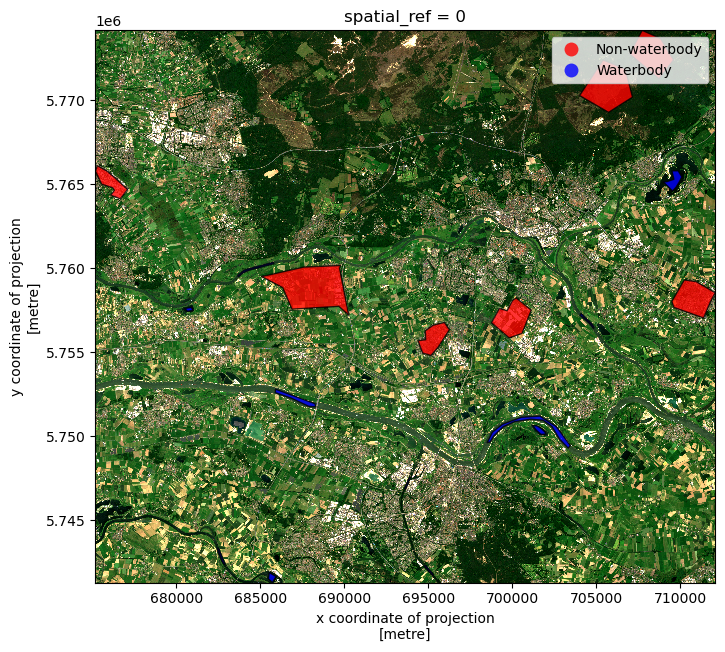

In [7]:
# Plot the polygon labels over the RGB cutout
labels_plot = labels.copy() # Make a copy for plotting
labels_plot['label'] = labels_plot['label'].replace({0: 'Non-waterbody', 1: 'Waterbody'})

# Create plot
fig, ax = plt.subplots(figsize=(8, 8))
rgb_cutout.plot.imshow(ax=ax, robust=True)
labels_plot.plot(
    ax=ax,
    column="label",
    alpha=0.8,
    edgecolor="k",
    legend=True,
    categorical=True,
    cmap="bwr_r"
)

The polygon labels have been manually created, marking examples of water bodies and non-water bodies.

## Covert labels from vector to raster

We use scikit-learn's `RandomForestClassifier` to train the model. First we need to convert the vector labels (polygons) to raster labels, since the classifier only accepts array-like data. We write a custom function `generate_label_array` to do this conversion.

Via this function, we create a single band array with the same spatial size as the RGB cutout, where the pixel values are 1 for waterbodies, 0 for non-waterbodies, and -1 for no label:

In [8]:
def generate_label_array(raster, labels):
    """
    Generate a label array from the raster and positive/negative vector labels.

    Parameters
    ----------
    raster : xarray.DataArray
        The input raster data.
    labels : geopandas.GeoDataFrame
        GeoDataFrame containing the labels. In the "label" column, 1 represents
        positive (waterbody) labels and 0 represents negative (non-waterbody)
        labels.

    Returns
    -------
    xarray.DataArray
        A label array where positive labels are 1, negative labels are 0, and
        areas without labels are -1.
    """
    # Separate positive and negative labels
    positive = labels[labels["label"] == 1]
    negative = labels[labels["label"] == 0]

    # Make positive labels
    pos_mask = xr.full_like(
        raster.isel(band=0).drop_vars("band"), fill_value=1, dtype=np.int32
    )
    pos_mask = pos_mask.rio.write_nodata(-1)
    pos_label_array = pos_mask.rio.clip(positive["geometry"], drop=False)

    # Make negative labels
    neg_mask = xr.full_like(
        raster.isel(band=0).drop_vars("band"), fill_value=0, dtype=np.int32
    )
    neg_mask = neg_mask.rio.write_nodata(-1)
    neg_label_array = neg_mask.rio.clip(negative["geometry"], drop=False)

    # Combine positive and negative labels
    label_array = -(pos_label_array * neg_label_array)

    return label_array

Then we can convert the labels to arrays, and visualize them once again over the RGB cutout:

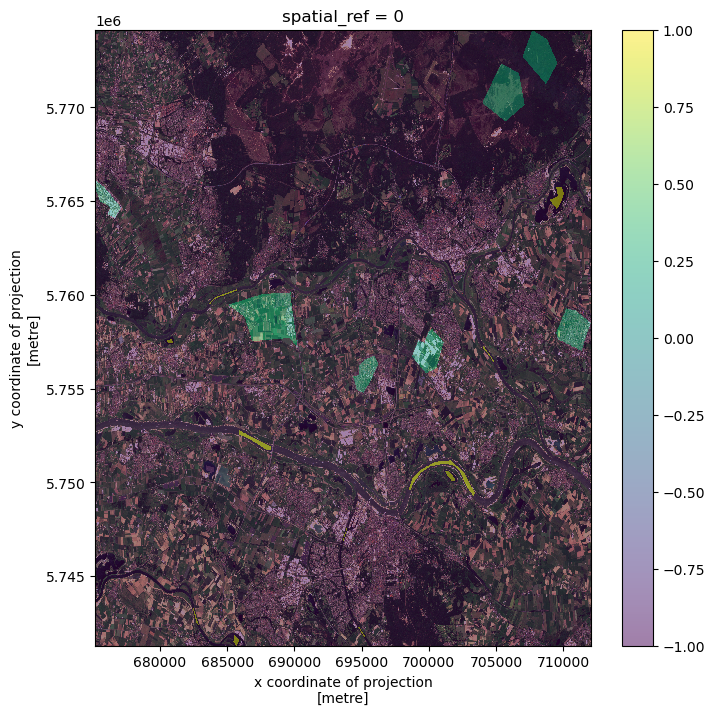

In [9]:
# Covert labels from vector to raster
label_array = generate_label_array(rgb_cutout, labels)

# Plot labels over the RGB image
fig, ax = plt.subplots(figsize=(8, 8))
rgb_cutout.plot.imshow(ax=ax, robust=True)
label_array.plot.imshow(ax=ax, vmin=-1, vmax=1, alpha=0.5)

## Prepare training data

Now the labels are ready. For training data, we can extract the RGB values at the pixel locations where labels are 1 (water bodies) or 0 (non-water bodies). We use each band of the RGB cutout, i.e., red, green, and blue, as features for the classifier.

We wrote a function `extract_training_data` to prepare the training data.

In [10]:
def prepare_training_data(image, labels):
    """
    Extract training data from the raster image/labels

    Parameters
    ----------
    image : np.ndarray

    labels : np.ndarray

    Returns
    -------
    train_data : np.ndarray
        Feature array
    train_labels : np.ndarray
        Label array
    """
    # Reshape input data to [n_instances, n_features]
    flattened = labels.flatten()
    positive_data = image.reshape((image.shape[0], -1))[:, flattened == 1].transpose()
    negative_data = image.reshape((image.shape[0], -1))[:, flattened == 0].transpose()
    positive_labels = np.full_like(positive_data[:,0], 1)
    negative_labels = np.full_like(negative_data[:,0], 0)
    train_data = np.concatenate((positive_data, negative_data))
    train_labels = np.concatenate((positive_labels, negative_labels))

    # Shuffle the training data
    indices = np.arange(train_data.shape[0])
    indices_shuffled = np.random.permutation(indices)
    return train_data[indices_shuffled], train_labels[indices_shuffled]

In [11]:
train_data, train_labels = prepare_training_data(rgb_cutout.data, label_array.data)

print(f"dimensions of training data: {train_data.shape}")
print(f"dimensions of training labels: {train_labels.shape}")

dimensions of training data: (324310, 3)
dimensions of training labels: (324310,)


## Train the Random Forest Classifier

Now we can train the `RandomForestClassifier` with the training data and labels and export the trained model for later use.


In [12]:
# This automatically computes the dask arrays to convert them to numpy arrays for training
classifier = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=8) # Limit the model size
classifier.fit(train_data, train_labels)

,n_estimators,100
,criterion,'gini'
,max_depth,8
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [13]:
# Export the trained classifier
joblib.dump(classifier, 'binary_classifier_waterbody.pkl')

['binary_classifier_waterbody.pkl']

## Inference on the cutout

Before applying the model to the full image, we can also run it on all the pixels of the cutout itself. Here for demonstration, we predict classification probabilities instead of the binary mask. The output is a raster dataset representing the probability for each pixel of being classified as water (label 1).

In [14]:
# Reshape rgb cutout as input for prediction
input = rgb_cutout.data.reshape((3, -1)).transpose()

# Load the trained classifier
classifier = joblib.load('binary_classifier_waterbody.pkl')

# Perform predictions
# This produces a two-column probability map for water and non-water areas
# First column is non-water, second column is water
# The sum of the two columns is 1
predictions = classifier.predict_proba(input)
predictions

array([[0.98771095, 0.01228905],
       [0.98603822, 0.01396178],
       [0.98771095, 0.01228905],
       ...,
       [0.96254571, 0.03745429],
       [0.91932772, 0.08067228],
       [0.97157494, 0.02842506]], shape=(12129030, 2))

In [15]:
# Only consider the waterbody probability
# Reshape predictions back to image dimensions for visualization
prediction_map = predictions[:, 1].reshape(rgb_cutout.data.shape[1], rgb_cutout.data.shape[2])

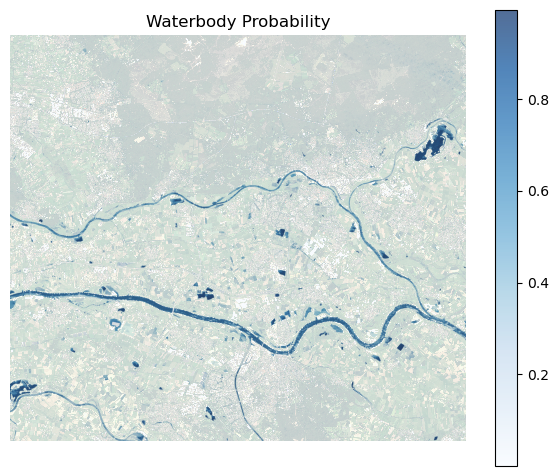

In [16]:
# Visualize the predictions
img_extent = (rgb_cutout.x.min(), rgb_cutout.x.max(), rgb_cutout.y.min(), rgb_cutout.y.max())
fig, ax = plt.subplots(figsize=(6, 6))
rgb_cutout.plot.imshow(ax=ax, alpha=0.6, robust=True)
ax.imshow(prediction_map, cmap='Blues', alpha=0.7, extent=img_extent)
ax.set_title('Waterbody Probability')
ax.axis('off')
plt.colorbar(ax.images[1], ax=ax, shrink=0.8)
plt.tight_layout()